# A Taste of Pytorch

Pytorch is a library used for training machine learning models, with a particular focus on deep learning. 

The basic building block are tensors, n-dimensional arrays similar to numpys array class. 
We can define a tensor as follows:

In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam
import torchvision
import torch.nn as nn

In [2]:
one_d_tensor = torch.tensor([1,2,3])
print(one_d_tensor)
two_d_tensor = torch.tensor([[11, 12],[21, 22]])
print(two_d_tensor)

tensor([1, 2, 3])
tensor([[11, 12],
        [21, 22]])


What makes pytorch so useful for defining machine learning modes is, that it can automatically compute derivatives to tensors. This capability is known as automatic differentiation. 
How this is used in Pytorch is demonstrated in the following code:

In [3]:
# a one-d tensor with value 2, for which we want 
# to compute a gradient
x = torch.tensor([2.0], requires_grad=True) 

# we can define arbitrary functions of x
def f(x):
    return 2 * x * x + 1

fx = f(x)

# backward is called to compute the derivative of f(x) with respect
# to all variables, which we marked with `requires_grad`. 
fx.backward()

# We can then access the derivative with respect to x at the 
# position x as follow
print(f"The gradient at position {x.item()} is: ", x.grad.item())

The gradient at position 2.0 is:  8.0


### Example 1: Linear regression 

We illustrate the usefulness of these concepts by defineing a simple linear regression model. 

First we create some ground truth data

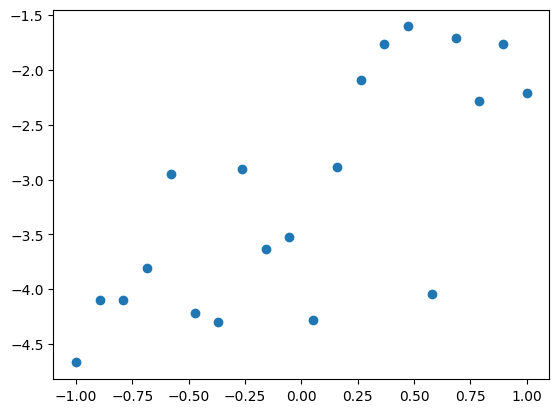

In [4]:
a_true = 1.3
b_true = -3.0
xs = torch.linspace(-1, 1, 20)
ys = a_true * xs + b_true +  torch.normal(mean = 0.0, std = 1.0, size=(len(xs), )) * 0.5
plt.plot(xs, ys, 'o')

Our model is then the simple regression model

In [5]:
a = torch.zeros((1,), requires_grad = True)
b = torch.zeros((1,), requires_grad = True)
    
def model(x): 
    return a * x + b

As a loss function we choose a simple mean squared error.

In [6]:
def loss_fn(ys, ys_pred):
    return ((ys - ys_pred)**2).mean()

This model is differtiable with respect to the parameters a and b. 
We can define an optimizer, that uses these gradients to compute
a minimum of the loss function:

In [7]:
optimizer = Adam([a, b], lr=0.02)

The main training loop can be written as follows:

In [8]:
for i in range(0, 1000):
    # make prediction and compute loss
    ys_pred = model(xs) 
    loss = loss_fn(ys, ys_pred) 
    
    # compute gradient
    optimizer.zero_grad()
    loss.backward()
    
    # go a step in the gradient direction
    optimizer.step()
    
    if (i % 50 == 0):
        print(f"loss in iteration {i}={loss.item()}")

loss in iteration 0=10.896418571472168
loss in iteration 50=5.278923988342285
loss in iteration 100=2.4175329208374023
loss in iteration 150=1.132476568222046
loss in iteration 200=0.6465954780578613
loss in iteration 250=0.4974604547023773
loss in iteration 300=0.4606266915798187
loss in iteration 350=0.4533218443393707
loss in iteration 400=0.4521596431732178
loss in iteration 450=0.4520118236541748
loss in iteration 500=0.45199689269065857
loss in iteration 550=0.45199570059776306
loss in iteration 600=0.4519956707954407
loss in iteration 650=0.4519956707954407
loss in iteration 700=0.4519956707954407
loss in iteration 750=0.4519956707954407
loss in iteration 800=0.4519956707954407
loss in iteration 850=0.4519956707954407
loss in iteration 900=0.4519956707954407
loss in iteration 950=0.4519956707954407


Let's plot the result

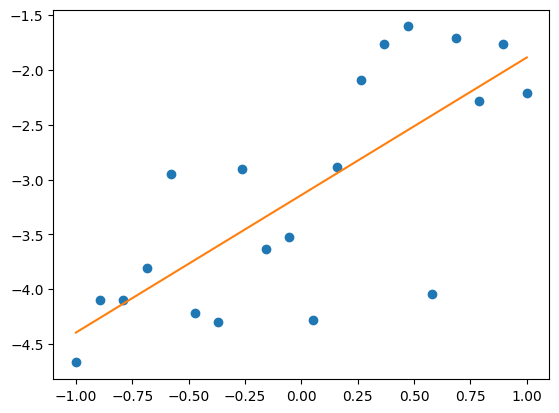

In [9]:
y_pred = model(xs)
plt.plot(xs, ys, 'o')
plt.plot(xs, y_pred.detach().numpy(), '-')


### Example 2 : Autoencoder

In the second example, we define an Autoencoder. This example illustrates two more aspect of pytorch: Namely the data loader and how to work with modules. It is not expected that you understand all the details or could implement it yourself. But it should give you a taste what working with pytorch is like and the power it gives you for defining machine learning models. 

### Loading the data

In this example we work with the MNIST hand written digit dataset.
While loading it, we also convert it to a pytorch tensor.


In [10]:
import torchvision.transforms as transforms

# Define transformations for the training 
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the training dataset
trainset = torchvision.datasets.MNIST(
    root='./data',  # Directory to save the dataset
    train=True,  # Specify training data
    download=True,  # Download if the dataset is not already present
    transform=transform  # Apply transformations
)

trainloader = torch.utils.data.DataLoader(
    trainset,  # Training dataset
    batch_size=64,  # Batch size
    shuffle=True  # Shuffle the data
)

# Verify the dataset loading
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f"Batch of images has shape: {images.shape}")
print(f"Batch of labels has shape: {labels.shape}")

Batch of images has shape: torch.Size([64, 1, 28, 28])
Batch of labels has shape: torch.Size([64])


It is helpful to visualize some images:

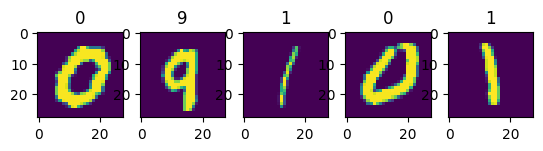

In [11]:
import matplotlib 
dataiter = iter(trainloader)
images, label = next(dataiter)

fig, axs = plt.subplots(1,5)
for i in range(0, 5):
    axs[i].imshow(images[i].view(28, 28).numpy())
    axs[i].set_title(label[i].item())

Now we define an encoder. We make use of pytorch Module to define it. We set up a network 
with 4 linears. Each has fewer neurons. The last layer only has 3 neurons. Hence we can encode our digits using 3 numbers only. 

In [40]:
# Define the Encoder model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


The decoder is a neural network that does the opposite of the encoder. It takes 3 numbers as inputs and decodes them into a full image again.  

In [39]:

# Define the Decoder model
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


An autoencoder is then just a module that encodes and decodes the image. 

In [41]:
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


As a loss function, we use the Mean Square Loss function, applied to the original image and the reconstructed image. Training the autoencoder means setting the parameters such, that each image can be compressed (encoded) to 3 numbers and decoded again, with a minimum error. 

In [42]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10 # An epoch is one pass through the data
for epoch in range(num_epochs): 
    for data in trainloader: # The data is divided in batches. We work through each batch
        img, _ = data
        img = img.view(img.size(0), -1)  # Flatten the images

        # run the image through the model and compare how well it reconstructs
        output = model(img)
        loss = criterion(output, img)

        # Compute gradients and take an optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0427
Epoch [2/10], Loss: 0.0416
Epoch [3/10], Loss: 0.0340
Epoch [4/10], Loss: 0.0385
Epoch [5/10], Loss: 0.0372
Epoch [6/10], Loss: 0.0380
Epoch [7/10], Loss: 0.0339
Epoch [8/10], Loss: 0.0310
Epoch [9/10], Loss: 0.0374
Epoch [10/10], Loss: 0.0325


Finally, we show some reconstructions. The upper row shows the true image, and the bottom row the reconstructed one. Remember, that we have compressed it each to 3 numbers using the encoder. Hence it is clear that the reconstructions are not perfect. 

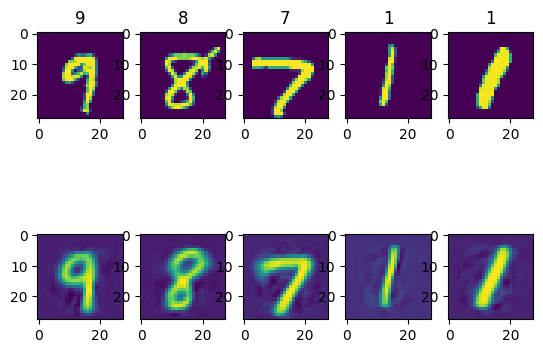

In [43]:
import matplotlib 
fig, axs = plt.subplots(2,5)
dataiter = iter(trainloader)

encoder = model.encoder

images, labels = next(dataiter)
for i in range(0, 5):
    img = images[i,:,:]
    z = encoder(img.view(-1, 28*28))
    decoded_img = model.decoder(z).view(28, 28)

    axs[0][i].set_title(labels[i].item())
    axs[0][i].imshow(img.view(28, 28).detach().numpy())    
    axs[1][i].imshow(decoded_img.detach().numpy())
